In [1]:
import sys

In [2]:
sys.path.insert(0, "/Users/shankari/e-mission/e-mission-server/")

In [3]:
sys.path

['/Users/shankari/e-mission/e-mission-server/',
 '',
 '/Users/shankari/OSS/anaconda/lib/python2.7/site-packages/pygmaps-0.1.1-py2.7.egg',
 '/Users/shankari/bin/python',
 '/Users/shankari/e-mission/data-collection-eval/analysis_dec_2015',
 '/Users/shankari/OSS/anaconda/python.app/Contents/lib/python27.zip',
 '/Users/shankari/OSS/anaconda/python.app/Contents/lib/python2.7',
 '/Users/shankari/OSS/anaconda/python.app/Contents/lib/python2.7/plat-darwin',
 '/Users/shankari/OSS/anaconda/python.app/Contents/lib/python2.7/plat-mac',
 '/Users/shankari/OSS/anaconda/python.app/Contents/lib/python2.7/plat-mac/lib-scriptpackages',
 '/Users/shankari/OSS/anaconda/python.app/Contents/lib/python2.7/lib-tk',
 '/Users/shankari/OSS/anaconda/python.app/Contents/lib/python2.7/lib-old',
 '/Users/shankari/OSS/anaconda/python.app/Contents/lib/python2.7/lib-dynload',
 '/Users/shankari/OSS/anaconda/lib/python2.7/site-packages',
 '/Users/shankari/OSS/anaconda/lib/python2.7/site-packages/PIL',
 '/Users/shankari/OSS

In [4]:
import logging
logging.getLogger().setLevel(logging.DEBUG)

In [5]:
from uuid import UUID

In [6]:
iphone_ids = [UUID("079e0f1a-c440-3d7c-b0e7-de160f748e35"), UUID("c76a0487-7e5a-3b17-a449-47be666b36f6"), UUID("c528bcd2-a88b-3e82-be62-ef4f2396967a")]
android_ids = [UUID("e471711e-bd14-3dbe-80b6-9c7d92ecc296"), UUID("fd7b4c2e-2c8b-3bfa-94f0-d1e3ecbd5fb7"), UUID("86842c35-da28-32ed-a90e-2da6663c5c73")]

In [7]:
import emission.core.get_database as edb

In [8]:
edb.get_timeseries_db().find({'user_id': iphone_ids[0]}).count()

9930

In [9]:
edb.get_timeseries_db().find({'user_id': iphone_ids[0], 'metadata.key': 'background/location'}).count()

781

In [175]:
import pandas as pd
import emission.storage.timeseries.abstract_timeseries as esta
import emission.net.usercache.abstract_usercache as enua
import emission.analysis.intake.cleaning.location_smoothing as eaicl

In [11]:
iphone_ts_list = [esta.TimeSeries.get_time_series(id) for id in iphone_ids]

In [12]:
android_ts_list = [esta.TimeSeries.get_time_series(id) for id in android_ids]

In [13]:
%matplotlib inline

In [14]:
import datetime as pydt

# Common functions

In [15]:
import matplotlib.pyplot as plt
import numpy as np

In [143]:
def generate_fake_dataframe(start, end, fill_val):
    x_axis = np.arange(start,end,30)
    y_axis = np.array(len(x_axis))
    y_axis.fill(fill_val)
    print "Fake data length = %d, fill_val = %d" % (len(x_axis), fill_val)
    # axes_array[i].set_xlim(start,end)
    return pd.DataFrame({"ts": x_axis, "latitude": y_axis})

In [185]:
def plot_for_transition(label, location_dfs, transition_dfs, axes_array, diff_axes_array, ground_truth_exit_ts, ground_truth_end_ts):
    # Find the mean latitudes so that we can create a dummy dataframe when there is no data
    lat_means = pd.Series(np.empty(len(location_dfs)))
    print "length of lat_means = %d" % len(lat_means)
    for i, df in enumerate(location_dfs):
        if len(df) > 0:
            lat_means[i] = df.latitude.mean()
        
    for i, df in enumerate(location_dfs):
        print "Considering phone %d" % i
        axes_array[i].axvline(x=ground_truth_exit_ts, linewidth=1, color="purple")
        axes_array[i].axvline(x=ground_truth_end_ts, linewidth=1, color="purple")
        axes_array[i].set_title(label + str(i))

        transition_df = transition_dfs[i]
        if len(df) == 0:
            print "No data to plot for dataframe %d" % i
            generate_fake_dataframe(ground_truth_exit_ts, ground_truth_end_ts, lat_means.mean()).plot(x="ts", y="latitude", kind="scatter", ax=axes_array[i])
            axes_array[i].annotate("No data for dataframe", xy=(0.3, 0.5), xycoords='axes fraction', fontsize=12, color="red")
        else:
            df[(df.ts > ground_truth_exit_ts) & (df.ts < ground_truth_end_ts)].plot(x="ts", y="latitude", kind="scatter", ax=axes_array[i])
            axes_array[i].axvline(x=ground_truth_exit_ts, linewidth=1, color="purple")
            if label.endswith("android"):
                diff_df = df[(df.ts > ground_truth_exit_ts) & (df.ts < ground_truth_end_ts)].ts.diff()
                print diff_df[diff_df > 30].head()
                diff_df.hist(ax=diff_axes_array[i])
                diff_axes_array[i].set_title("histogram of time diffs")
            else:
                assert(label.endswith("iphone"))
                with_distances = eaicl.add_dist_heading_speed(df)
                with_distances.distance.diff().abs().hist(ax=diff_axes_array[i])
                diff_axes_array[i].set_title("histogram of distance diffs")


        if len(transition_df) == 0 or np.count_nonzero(transition_df.transition == 1) == 0:
            print("len(transition_df) = %d, ground_truth_exit_ts = %d, geofence was not exited!!" % 
                  (len(transition_df), ground_truth_exit_ts))
            axes_array[i].annotate("Geofence was not exited!", xy=(0.3, 0.2), xycoords='axes fraction', fontsize=12, color="blue")            
        else:
            trip_geofence_exit_entry = transition_df[transition_df.transition == 1].iloc[0]
            trip_geofence_exit_ts = trip_geofence_exit_entry["ts"]
            axes_array[i].axvline(x=trip_geofence_exit_ts, linewidth=1, color="green")
            if len(df) > 0:
                after_geofence_exit_points = df[(df.ts >= trip_geofence_exit_ts) & (df.ts <= ground_truth_end_ts)]
                if len(after_geofence_exit_points) > 0:
                    first_location_entry = after_geofence_exit_points.iloc[0]
                    print("ground truth exit = %s, geofence_exit_ts = +%5f, first location point = +%5f" %
                          (pydt.datetime.fromtimestamp(ground_truth_exit_ts),
                         (trip_geofence_exit_ts - ground_truth_exit_ts),
                         (first_location_entry.ts - ground_truth_exit_ts)))

In [164]:
def evaluate_trip_accuracy(label, start, end):
    print "Generating trip for %s" % label
    iphone_df_list = [ts.get_data_df("background/location", enua.UserCache.TimeQuery("write_ts", start, end)) for ts in iphone_ts_list]
    android_df_list = [ts.get_data_df("background/location", enua.UserCache.TimeQuery("write_ts", start, end)) for ts in android_ts_list]
    iphone_transition_df_list = [ts.get_data_df("statemachine/transition", enua.UserCache.TimeQuery("write_ts", start, end)) for ts in iphone_ts_list]
    android_transition_df_list = [ts.get_data_df("statemachine/transition", enua.UserCache.TimeQuery("write_ts", start, end)) for ts in android_ts_list]
    insert_transition_strings(iphone_transition_df_list)
    insert_transition_strings(android_transition_df_list)
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,5), sharex=True, sharey=True)
    diff_fig, diff_axes = plt.subplots(nrows=2, ncols=3, figsize=(15,5))
    plot_for_transition(label + " iphone", iphone_df_list, iphone_transition_df_list, axes[0], diff_axes[0], start, end)
    plot_for_transition(label + " android", android_df_list, android_transition_df_list, axes[1], diff_axes[1], start, end)
    return fig, diff_fig

In [124]:
import emission.core.wrapper.transition as ecwt

In [125]:
def insert_transition_strings(df_list):
    for df in df_list:
        if len(df) > 0:
            df["transition_str"] = df.transition.map(lambda(tval): ecwt.TransitionType(tval))

# Determine transitions

In [126]:
all_iphone_transition_df = [ts.get_data_df("statemachine/transition", enua.UserCache.TimeQuery("write_ts", 1448915908.41, 1449002308)) for ts in iphone_ts_list]

DEBUG:root:curr_query = {'$or': [{'metadata.key': 'statemachine/transition'}], 'metadata.write_ts': {'$gte': 1448915908.41, '$lt': 1449002308}, 'user_id': UUID('079e0f1a-c440-3d7c-b0e7-de160f748e35')}, sort_key = metadata.write_ts
DEBUG:root:Found 0 results
DEBUG:root:curr_query = {'$or': [{'metadata.key': 'statemachine/transition'}], 'metadata.write_ts': {'$gte': 1448915908.41, '$lt': 1449002308}, 'user_id': UUID('c76a0487-7e5a-3b17-a449-47be666b36f6')}, sort_key = metadata.write_ts
DEBUG:root:Found 146 results
DEBUG:root:curr_query = {'$or': [{'metadata.key': 'statemachine/transition'}], 'metadata.write_ts': {'$gte': 1448915908.41, '$lt': 1449002308}, 'user_id': UUID('c528bcd2-a88b-3e82-be62-ef4f2396967a')}, sort_key = metadata.write_ts
DEBUG:root:Found 138 results


In [127]:
all_android_transition_df = [ts.get_data_df("statemachine/transition", enua.UserCache.TimeQuery("write_ts", 1448915908.41, 1449002308)) for ts in android_ts_list]

DEBUG:root:curr_query = {'$or': [{'metadata.key': 'statemachine/transition'}], 'metadata.write_ts': {'$gte': 1448915908.41, '$lt': 1449002308}, 'user_id': UUID('e471711e-bd14-3dbe-80b6-9c7d92ecc296')}, sort_key = metadata.write_ts
DEBUG:root:Found 19 results
DEBUG:root:curr_query = {'$or': [{'metadata.key': 'statemachine/transition'}], 'metadata.write_ts': {'$gte': 1448915908.41, '$lt': 1449002308}, 'user_id': UUID('fd7b4c2e-2c8b-3bfa-94f0-d1e3ecbd5fb7')}, sort_key = metadata.write_ts
DEBUG:root:Found 18 results
DEBUG:root:curr_query = {'$or': [{'metadata.key': 'statemachine/transition'}], 'metadata.write_ts': {'$gte': 1448915908.41, '$lt': 1449002308}, 'user_id': UUID('86842c35-da28-32ed-a90e-2da6663c5c73')}, sort_key = metadata.write_ts
DEBUG:root:Found 12 results


In [128]:
insert_transition_strings(all_iphone_transition_df + all_android_transition_df)

In [129]:
for df in all_android_transition_df:
    if len(df) > 0:
        print df[(df.transition == 1) | (df.transition == 2)][["fmt_time", "transition_str"]]

                            fmt_time                  transition_str
1   2015-11-30T12:49:39.190000-08:00  TransitionType.EXITED_GEOFENCE
2   2015-11-30T13:03:12.812000-08:00   TransitionType.STOPPED_MOVING
3   2015-11-30T14:35:56.696000-08:00  TransitionType.EXITED_GEOFENCE
4   2015-11-30T14:46:37.094000-08:00   TransitionType.STOPPED_MOVING
5   2015-11-30T15:18:16.935000-08:00  TransitionType.EXITED_GEOFENCE
6   2015-11-30T15:27:14.620000-08:00   TransitionType.STOPPED_MOVING
7   2015-11-30T15:46:41.497000-08:00  TransitionType.EXITED_GEOFENCE
8   2015-11-30T15:56:26.862000-08:00   TransitionType.STOPPED_MOVING
9   2015-11-30T16:06:06.390000-08:00  TransitionType.EXITED_GEOFENCE
10  2015-11-30T16:20:34.290000-08:00   TransitionType.STOPPED_MOVING
11  2015-11-30T16:52:38.199000-08:00  TransitionType.EXITED_GEOFENCE
12  2015-11-30T17:07:40.371000-08:00   TransitionType.STOPPED_MOVING
13  2015-11-30T19:42:31.756000-08:00  TransitionType.EXITED_GEOFENCE
14  2015-11-30T19:57:51.103000-08:

In [130]:
for df in all_android_transition_df:
    if len(df) > 0:
        for idx, row in df[(df.transition == 1) | (df.transition == 2)].iterrows():
            print row["fmt_time"], row["ts"]

2015-11-30T12:49:39.190000-08:00 1448916579.19
2015-11-30T13:03:12.812000-08:00 1448917392.81
2015-11-30T14:35:56.696000-08:00 1448922956.7
2015-11-30T14:46:37.094000-08:00 1448923597.09
2015-11-30T15:18:16.935000-08:00 1448925496.93
2015-11-30T15:27:14.620000-08:00 1448926034.62
2015-11-30T15:46:41.497000-08:00 1448927201.5
2015-11-30T15:56:26.862000-08:00 1448927786.86
2015-11-30T16:06:06.390000-08:00 1448928366.39
2015-11-30T16:20:34.290000-08:00 1448929234.29
2015-11-30T16:52:38.199000-08:00 1448931158.2
2015-11-30T17:07:40.371000-08:00 1448932060.37
2015-11-30T19:42:31.756000-08:00 1448941351.76
2015-11-30T19:57:51.103000-08:00 1448942271.1
2015-11-30T20:10:05.430000-08:00 1448943005.43
2015-11-30T20:16:23.329000-08:00 1448943383.33
2015-11-30T20:21:30.427000-08:00 1448943690.43
2015-11-30T20:38:17.810000-08:00 1448944697.81
2015-11-30T12:48:52.063000-08:00 1448916532.06
2015-11-30T13:02:11.140000-08:00 1448917331.14
2015-11-30T14:34:56.849000-08:00 1448922896.85
2015-11-30T14:46:

In [131]:
for df in all_iphone_transition_df:
    if len(df) > 0:
        print df[(df.transition == 1) | (df.transition == 2)][["fmt_time", "transition_str"]]

                             fmt_time                  transition_str
0    2015-11-30T12:51:53.161843-08:00  TransitionType.EXITED_GEOFENCE
1    2015-11-30T12:51:53.161843-08:00  TransitionType.EXITED_GEOFENCE
27   2015-11-30T14:00:05.378099-08:00   TransitionType.STOPPED_MOVING
28   2015-11-30T14:00:05.378099-08:00   TransitionType.STOPPED_MOVING
29   2015-11-30T14:00:05.378099-08:00   TransitionType.STOPPED_MOVING
30   2015-11-30T14:00:05.378099-08:00   TransitionType.STOPPED_MOVING
31   2015-11-30T14:00:05.378099-08:00   TransitionType.STOPPED_MOVING
32   2015-11-30T14:00:05.646480-08:00   TransitionType.STOPPED_MOVING
33   2015-11-30T14:00:05.646480-08:00   TransitionType.STOPPED_MOVING
34   2015-11-30T14:00:05.646480-08:00   TransitionType.STOPPED_MOVING
35   2015-11-30T14:00:05.646480-08:00   TransitionType.STOPPED_MOVING
36   2015-11-30T14:00:05.646480-08:00   TransitionType.STOPPED_MOVING
37   2015-11-30T14:40:22.818389-08:00  TransitionType.EXITED_GEOFENCE
38   2015-11-30T14:4

So trips are:
- Around the block:
 - 2015-11-30T12:47:04.063000-08:00, 1448916532.06
 - 2015-11-30T13:02:11.140000-08:00, 1448917331.14
- To Kaiser:
 - 2015-11-30T14:33:30.849000-08:00, 1448922810.145
 - 2015-11-30T14:41:28.849000-08:00, 1448923288.849
- From Kaiser:
 - 2015-11-30T15:14:13.415000-08:00, 1448925253.415
 - 2015-11-30T15:28:27.879000-08:00, 1448926107.88
- To Karate: 
 - 2015-11-30T16:03:15.834000-08:00, 1448928195.834
 - 2015-11-30T16:20:04.251000-08:00, 1448929204.25 (no ground truth)
- From Karate:
 - 2015-11-30T16:45:59.259000-08:00, 1448930759.259 (no ground truth, estimate)
 - 2015-11-30T17:07:42.867000-08:00, 1448932062.87 (no ground truth, estimate)
- To Books Inc:
 - 2015-11-30T19:41:14.384000-08:00, 1448941274.384
 - 2015-11-30T19:57:32.101000-08:00, 1448942252.1 (no ground truth, estimate)
- From Books Inc:
 - 2015-11-30T20:18:18.145000-08:00, 1448943498.145
 - 2015-11-30T20:34:29.145000-08:00 1448944469.145 (no ground truth, super estimate)

In [171]:
# And in code:
trips_list = [["around_the_block", 1448916532.06, 1448917331.14],
              ["to_kaiser", 1448922810.145, 1448923288.849],
              ["from_kaiser", 1448925253.415, 1448926107.88],
              ["to_karate", 1448928195.834, 1448929204.25],
              ["from_karate", 1448930759.259, 1448932062.87],
              ["to_books_inc", 1448941274.384, 1448942252.1],
              ["from_books_inc", 1448943498.145, 1448944469.145]
]

Phones had different geofence radii - 100m, 50m and 5m. The tracking regime was the same - 100m, kCLLocationAccuracyHundredMeters.
* Looks like fine tracking never restarted for phone1.
* phone3 is weird. It looks like it has coarse tracking until around the corner of Covington and Miramonte and then it gets fine?!

DEBUG:root:curr_query = {'$or': [{'metadata.key': 'background/location'}], 'metadata.write_ts': {'$gte': 1448916532.06, '$lt': 1448917331.14}, 'user_id': UUID('079e0f1a-c440-3d7c-b0e7-de160f748e35')}, sort_key = metadata.write_ts
DEBUG:root:Found 8 results
DEBUG:root:curr_query = {'$or': [{'metadata.key': 'background/location'}], 'metadata.write_ts': {'$gte': 1448916532.06, '$lt': 1448917331.14}, 'user_id': UUID('c76a0487-7e5a-3b17-a449-47be666b36f6')}, sort_key = metadata.write_ts
DEBUG:root:Found 12 results
DEBUG:root:curr_query = {'$or': [{'metadata.key': 'background/location'}], 'metadata.write_ts': {'$gte': 1448916532.06, '$lt': 1448917331.14}, 'user_id': UUID('c528bcd2-a88b-3e82-be62-ef4f2396967a')}, sort_key = metadata.write_ts
DEBUG:root:Found 25 results
DEBUG:root:curr_query = {'$or': [{'metadata.key': 'background/location'}], 'metadata.write_ts': {'$gte': 1448916532.06, '$lt': 1448917331.14}, 'user_id': UUID('e471711e-bd14-3dbe-80b6-9c7d92ecc296')}, sort_key = metadata.write_

Generating trip for around_the_block
length of lat_means = 3
Considering phone 0
len(transition_df) = 0, ground_truth_exit_ts = 1448916532, geofence was not exited!!

DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root


Considering phone 1
ground truth exit = 2015-11-30 12:48:52.060000, geofence_exit_ts = +181.101843, first location point = +205.527100
Considering phone 2
ground truth exit = 2015-11-30 12:48:52.060000, geofence_exit_ts = +223.455756, first location point = +223.547761
length of lat_means = 3
Considering phone 0
2    32
3    32
4    32
5    33
6    33
Name: ts, dtype: float64
ground truth exit = 2015-11-30 12:48:52.060000, geofence_exit_ts = +47.130000, first location point = +77.940000
Considering phone 1
2    34
3    32
4    32
5    33
6    33
Name: ts, dtype: float64
ground truth exit = 2015-11-30 12:48:52.060000, geofence_exit_ts = +0.003000, first location point = +28.940000
Considering phone 2
1    32
3    33
4    31
5    33
6    33
Name: ts, dtype: float64
ground truth exit = 2015-11-30 12:48:52.060000, geofence_exit_ts = +44.849000, first location point = +76.940000


(<matplotlib.figure.Figure at 0x11f934690>,
 <matplotlib.figure.Figure at 0x120b96c10>)

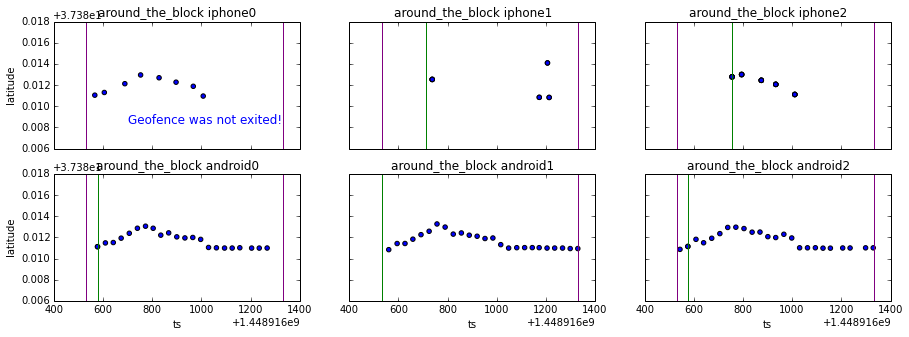

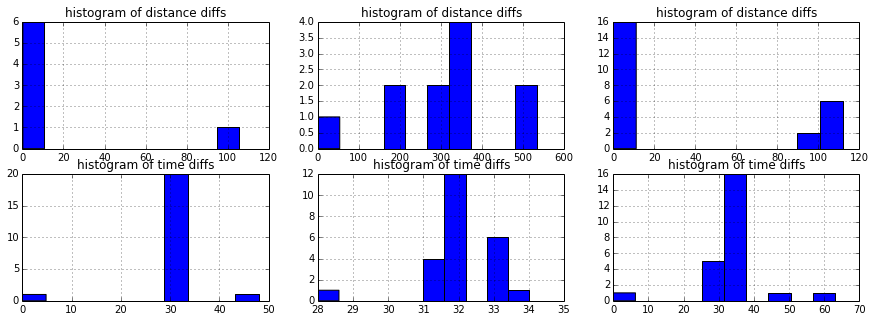

In [186]:
evaluate_trip_accuracy("around_the_block", 1448916532.06, 1448917331.14)

DEBUG:root:curr_query = {'$or': [{'metadata.key': 'background/location'}], 'metadata.write_ts': {'$gte': 1448916532.06, '$lt': 1448917331.14}, 'user_id': UUID('079e0f1a-c440-3d7c-b0e7-de160f748e35')}, sort_key = metadata.write_ts
DEBUG:root:Found 8 results
DEBUG:root:curr_query = {'$or': [{'metadata.key': 'background/location'}], 'metadata.write_ts': {'$gte': 1448916532.06, '$lt': 1448917331.14}, 'user_id': UUID('c76a0487-7e5a-3b17-a449-47be666b36f6')}, sort_key = metadata.write_ts
DEBUG:root:Found 12 results
DEBUG:root:curr_query = {'$or': [{'metadata.key': 'background/location'}], 'metadata.write_ts': {'$gte': 1448916532.06, '$lt': 1448917331.14}, 'user_id': UUID('c528bcd2-a88b-3e82-be62-ef4f2396967a')}, sort_key = metadata.write_ts
DEBUG:root:Found 25 results
DEBUG:root:curr_query = {'$or': [{'metadata.key': 'background/location'}], 'metadata.write_ts': {'$gte': 1448916532.06, '$lt': 1448917331.14}, 'user_id': UUID('e471711e-bd14-3dbe-80b6-9c7d92ecc296')}, sort_key = metadata.write_

Generating trip for around_the_block
length of lat_means = 3
Considering phone 0
len(transition_df) = 0, ground_truth_exit_ts = 1448916532, geofence was not exited!!

DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root


Considering phone 1
ground truth exit = 2015-11-30 12:48:52.060000, geofence_exit_ts = +181.101843, first location point = +205.527100
Considering phone 2
ground truth exit = 2015-11-30 12:48:52.060000, geofence_exit_ts = +223.455756, first location point = +223.547761
length of lat_means = 3
Considering phone 0
2    32
3    32
4    32
5    33
6    33
Name: ts, dtype: float64
ground truth exit = 2015-11-30 12:48:52.060000, geofence_exit_ts = +47.130000, first location point = +77.940000
Considering phone 1
2    34
3    32
4    32
5    33
6    33
Name: ts, dtype: float64
ground truth exit = 2015-11-30 12:48:52.060000, geofence_exit_ts = +0.003000, first location point = +28.940000
Considering phone 2
1    32
3    33
4    31
5    33
6    33
Name: ts, dtype: float64
ground truth exit = 2015-11-30 12:48:52.060000, geofence_exit_ts = +44.849000, first location point = +76.940000

DEBUG:root:curr_query = {'$or': [{'metadata.key': 'background/location'}], 'metadata.write_ts': {'$gte': 1448922810.145, '$lt': 1448923288.849}, 'user_id': UUID('079e0f1a-c440-3d7c-b0e7-de160f748e35')}, sort_key = metadata.write_ts
DEBUG:root:Found 5 results
DEBUG:root:curr_query = {'$or': [{'metadata.key': 'background/location'}], 'metadata.write_ts': {'$gte': 1448922810.145, '$lt': 1448923288.849}, 'user_id': UUID('c76a0487-7e5a-3b17-a449-47be666b36f6')}, sort_key = metadata.write_ts
DEBUG:root:Found 3 results
DEBUG:root:curr_query = {'$or': [{'metadata.key': 'background/location'}], 'metadata.write_ts': {'$gte': 1448922810.145, '$lt': 1448923288.849}, 'user_id': UUID('c528bcd2-a88b-3e82-be62-ef4f2396967a')}, sort_key = metadata.write_ts
DEBUG:root:Found 9 results
DEBUG:root:curr_query = {'$or': [{'metadata.key': 'background/location'}], 'metadata.write_ts': {'$gte': 1448922810.145, '$lt': 1448923288.849}, 'user_id': UUID('e471711e-bd14-3dbe-80b6-9c7d92ecc296')}, sort_key = metadata.


Generating trip for to_kaiser
length of lat_means = 3
Considering phone 0
len(transition_df) = 0, ground_truth_exit_ts = 1448922810, geofence was not exited!!

DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0



Considering phone 1
ground truth exit = 2015-11-30 14:33:30.145000, geofence_exit_ts = +412.673389, first location point = +412.747689
Considering phone 2
ground truth exit = 2015-11-30 14:33:30.145000, geofence_exit_ts = +453.097429, first location point = +453.208482
length of lat_means = 3
Considering phone 0
2    42
3    32
4    33
5    32
6    33
Name: ts, dtype: float64
ground truth exit = 2015-11-30 14:33:30.145000, geofence_exit_ts = +146.551000, first location point = +186.855000
Considering phone 1
2    33
3    32
4    33
5    32
6    32
Name: ts, dtype: float64
ground truth exit = 2015-11-30 14:33:30.145000, geofence_exit_ts = +86.704000, first location point = +118.855000
Considering phone 2
2    32
3    32
4    32
5    32
6    32
Name: ts, dtype: float64

DEBUG:root:curr_query = {'$or': [{'metadata.key': 'background/location'}], 'metadata.write_ts': {'$gte': 1448925253.415, '$lt': 1448926107.88}, 'user_id': UUID('079e0f1a-c440-3d7c-b0e7-de160f748e35')}, sort_key = metadata.write_ts
DEBUG:root:Found 7 results
DEBUG:root:curr_query = {'$or': [{'metadata.key': 'background/location'}], 'metadata.write_ts': {'$gte': 1448925253.415, '$lt': 1448926107.88}, 'user_id': UUID('c76a0487-7e5a-3b17-a449-47be666b36f6')}, sort_key = metadata.write_ts
DEBUG:root:Found 4 results
DEBUG:root:curr_query = {'$or': [{'metadata.key': 'background/location'}], 'metadata.write_ts': {'$gte': 1448925253.415, '$lt': 1448926107.88}, 'user_id': UUID('c528bcd2-a88b-3e82-be62-ef4f2396967a')}, sort_key = metadata.write_ts
DEBUG:root:Found 3 results
DEBUG:root:curr_query = {'$or': [{'metadata.key': 'background/location'}], 'metadata.write_ts': {'$gte': 1448925253.415, '$lt': 1448926107.88}, 'user_id': UUID('e471711e-bd14-3dbe-80b6-9c7d92ecc296')}, sort_key = metadata.writ


ground truth exit = 2015-11-30 14:33:30.145000, geofence_exit_ts = +51.232000, first location point = +81.855000
Generating trip for from_kaiser
length of lat_means = 3
Considering phone 0
len(transition_df) = 0, ground_truth_exit_ts = 1448925253, geofence was not exited!!
Considering phone 1
ground truth exit = 2015-11-30 15:14:13.415000, geofence_exit_ts = +516.114941, first location point = +516.191939
Considering phone 2
ground truth exit = 2015-11-30 15:14:13.415000, geofence_exit_ts = +470.318686, first location point = +470.461134
length of lat_means = 3
Considering phone 0
1    32
2    31
3    33
4    32
5    32
Name: ts, dtype: float64
ground truth exit = 2015-11-30 15:14:13.415000, geofence_exit_ts = +243.520000, first location point = +273.585000
Considering phone 1
2    34
3    32
4    33
5    32
6    33
Name: ts, dtype: float64
ground truth exit = 2015-11-30 15:14:13.415000, geofence_exit_ts = +212.000000, first location point = +244.585000

DEBUG:root:curr_query = {'$or': [{'metadata.key': 'background/location'}], 'metadata.write_ts': {'$gte': 1448928195.834, '$lt': 1448929204.25}, 'user_id': UUID('079e0f1a-c440-3d7c-b0e7-de160f748e35')}, sort_key = metadata.write_ts
DEBUG:root:Found 18 results
DEBUG:root:curr_query = {'$or': [{'metadata.key': 'background/location'}], 'metadata.write_ts': {'$gte': 1448928195.834, '$lt': 1448929204.25}, 'user_id': UUID('c76a0487-7e5a-3b17-a449-47be666b36f6')}, sort_key = metadata.write_ts
DEBUG:root:Found 8 results
DEBUG:root:curr_query = {'$or': [{'metadata.key': 'background/location'}], 'metadata.write_ts': {'$gte': 1448928195.834, '$lt': 1448929204.25}, 'user_id': UUID('c528bcd2-a88b-3e82-be62-ef4f2396967a')}, sort_key = metadata.write_ts
DEBUG:root:Found 12 results
DEBUG:root:curr_query = {'$or': [{'metadata.key': 'background/location'}], 'metadata.write_ts': {'$gte': 1448928195.834, '$lt': 1448929204.25}, 'user_id': UUID('e471711e-bd14-3dbe-80b6-9c7d92ecc296')}, sort_key = metadata.wr


Considering phone 2
1    32
2    52
3    32
4    32
5    33
Name: ts, dtype: float64
ground truth exit = 2015-11-30 15:14:13.415000, geofence_exit_ts = +502.496000, first location point = +534.585000
Generating trip for to_karate
length of lat_means = 3
Considering phone 0
len(transition_df) = 0, ground_truth_exit_ts = 1448928195, geofence was not exited!!
Considering phone 1
len(transition_df) = 0, ground_truth_exit_ts = 1448928195, geofence was not exited!!
Considering phone 2
len(transition_df) = 0, ground_truth_exit_ts = 1448928195, geofence was not exited!!
length of lat_means = 3
Considering phone 0
1     74
2     35
3     33
10    31
19    36
Name: ts, dtype: float64
ground truth exit = 2015-11-30 16:03:15.834000, geofence_exit_ts = +170.556000, first location point = +242.166000
Considering phone 1
1     94
2     32
3     34
9     31
19    34
Name: ts, dtype: float64
ground truth exit = 2015-11-30 16:03:15.834000, geofence_exit_ts = +240.000000, first location point = +240.166

DEBUG:root:curr_query = {'$or': [{'metadata.key': 'background/location'}], 'metadata.write_ts': {'$gte': 1448930759.259, '$lt': 1448932062.87}, 'user_id': UUID('079e0f1a-c440-3d7c-b0e7-de160f748e35')}, sort_key = metadata.write_ts
DEBUG:root:Found 36 results
DEBUG:root:curr_query = {'$or': [{'metadata.key': 'background/location'}], 'metadata.write_ts': {'$gte': 1448930759.259, '$lt': 1448932062.87}, 'user_id': UUID('c76a0487-7e5a-3b17-a449-47be666b36f6')}, sort_key = metadata.write_ts
DEBUG:root:Found 37 results
DEBUG:root:curr_query = {'$or': [{'metadata.key': 'background/location'}], 'metadata.write_ts': {'$gte': 1448930759.259, '$lt': 1448932062.87}, 'user_id': UUID('c528bcd2-a88b-3e82-be62-ef4f2396967a')}, sort_key = metadata.write_ts
DEBUG:root:Found 36 results
DEBUG:root:curr_query = {'$or': [{'metadata.key': 'background/location'}], 'metadata.write_ts': {'$gte': 1448930759.259, '$lt': 1448932062.87}, 'user_id': UUID('e471711e-bd14-3dbe-80b6-9c7d92ecc296')}, sort_key = metadata.w


ground truth exit = 2015-11-30 16:03:15.834000, geofence_exit_ts = +175.582000, first location point = +205.166000
Generating trip for from_karate
length of lat_means = 3
Considering phone 0
len(transition_df) = 0, ground_truth_exit_ts = 1448930759, geofence was not exited!!
Considering phone 1
len(transition_df) = 0, ground_truth_exit_ts = 1448930759, geofence was not exited!!
Considering phone 2
len(transition_df) = 0, ground_truth_exit_ts = 1448930759, geofence was not exited!!
length of lat_means = 3
Considering phone 0
2     34
3     31
6     31
10    31
12    31
Name: ts, dtype: float64
ground truth exit = 2015-11-30 16:45:59.259000, geofence_exit_ts = +398.940000, first location point = +429.741000
Considering phone 1
2     52
3     34
6     31
13    31
15    31
Name: ts, dtype: float64
ground truth exit = 2015-11-30 16:45:59.259000, geofence_exit_ts = +420.000000, first location point = +437.741000
Considering phone 2
1    61
2    49
3    32
4    32
6    31
Name: ts, dtype: fl

DEBUG:root:curr_query = {'$or': [{'metadata.key': 'background/location'}], 'metadata.write_ts': {'$gte': 1448941274.384, '$lt': 1448942252.1}, 'user_id': UUID('079e0f1a-c440-3d7c-b0e7-de160f748e35')}, sort_key = metadata.write_ts
DEBUG:root:Found 7 results
DEBUG:root:curr_query = {'$or': [{'metadata.key': 'background/location'}], 'metadata.write_ts': {'$gte': 1448941274.384, '$lt': 1448942252.1}, 'user_id': UUID('c76a0487-7e5a-3b17-a449-47be666b36f6')}, sort_key = metadata.write_ts
DEBUG:root:Found 18 results
DEBUG:root:curr_query = {'$or': [{'metadata.key': 'background/location'}], 'metadata.write_ts': {'$gte': 1448941274.384, '$lt': 1448942252.1}, 'user_id': UUID('c528bcd2-a88b-3e82-be62-ef4f2396967a')}, sort_key = metadata.write_ts
DEBUG:root:Found 0 results
DEBUG:root:curr_query = {'$or': [{'metadata.key': 'background/location'}], 'metadata.write_ts': {'$gte': 1448941274.384, '$lt': 1448942252.1}, 'user_id': UUID('e471711e-bd14-3dbe-80b6-9c7d92ecc296')}, sort_key = metadata.write_t


len(transition_df) = 0, ground_truth_exit_ts = 1448930759, geofence was not exited!!
Generating trip for to_books_inc
length of lat_means = 3
Considering phone 0
len(transition_df) = 0, ground_truth_exit_ts = 1448941274, geofence was not exited!!

DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0



Considering phone 1
ground truth exit = 2015-11-30 19:41:14.384000, geofence_exit_ts = +324.723893, first location point = +324.970891
Considering phone 2
No data to plot for dataframe 2
Fake data length = 33, fill_val = 24
length of lat_means = 3
Considering phone 0
2    35
3    32
4    32
5    32
6    32
Name: ts, dtype: float64
ground truth exit = 2015-11-30 19:41:14.384000, geofence_exit_ts = +77.372000, first location point = +110.616000
Considering phone 1
2    33
3    32
4    32
5    32
6    33
Name: ts, dtype: float64
ground truth exit = 2015-11-30 19:41:14.384000, geofence_exit_ts = +123.000000, first location point = +155.616000
Considering phone 2
1    31
3    33
4    32
5    32
6    31
Name: ts, dtype: float64

DEBUG:root:curr_query = {'$or': [{'metadata.key': 'background/location'}], 'metadata.write_ts': {'$gte': 1448943498.145, '$lt': 1448944469.145}, 'user_id': UUID('079e0f1a-c440-3d7c-b0e7-de160f748e35')}, sort_key = metadata.write_ts
DEBUG:root:Found 9 results
DEBUG:root:curr_query = {'$or': [{'metadata.key': 'background/location'}], 'metadata.write_ts': {'$gte': 1448943498.145, '$lt': 1448944469.145}, 'user_id': UUID('c76a0487-7e5a-3b17-a449-47be666b36f6')}, sort_key = metadata.write_ts
DEBUG:root:Found 54 results
DEBUG:root:curr_query = {'$or': [{'metadata.key': 'background/location'}], 'metadata.write_ts': {'$gte': 1448943498.145, '$lt': 1448944469.145}, 'user_id': UUID('c528bcd2-a88b-3e82-be62-ef4f2396967a')}, sort_key = metadata.write_ts
DEBUG:root:Found 18 results
DEBUG:root:curr_query = {'$or': [{'metadata.key': 'background/location'}], 'metadata.write_ts': {'$gte': 1448943498.145, '$lt': 1448944469.145}, 'user_id': UUID('e471711e-bd14-3dbe-80b6-9c7d92ecc296')}, sort_key = metadat


ground truth exit = 2015-11-30 19:41:14.384000, geofence_exit_ts = +63.905000, first location point = +96.616000
Generating trip for from_books_inc
length of lat_means = 3
Considering phone 0
len(transition_df) = 0, ground_truth_exit_ts = 1448943498, geofence was not exited!!

DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root


Considering phone 1
len(transition_df) = 0, ground_truth_exit_ts = 1448943498, geofence was not exited!!

DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0
DEBUG:root:timeDelta = 0, distanceDelta = %s, returning speed = 0



Considering phone 2
len(transition_df) = 0, ground_truth_exit_ts = 1448943498, geofence was not exited!!
length of lat_means = 3
Considering phone 0
2    37
3    32
4    32
5    32
6    33
Name: ts, dtype: float64
ground truth exit = 2015-11-30 20:18:18.145000, geofence_exit_ts = +192.282000, first location point = +228.855000
Considering phone 1
1    41
2    33
3    32
4    32
5    32
Name: ts, dtype: float64
len(transition_df) = 0, ground_truth_exit_ts = 1448943498, geofence was not exited!!
Considering phone 2
2    32
3    33
4    63
5    35
6    32
Name: ts, dtype: float64
len(transition_df) = 0, ground_truth_exit_ts = 1448943498, geofence was not exited!!


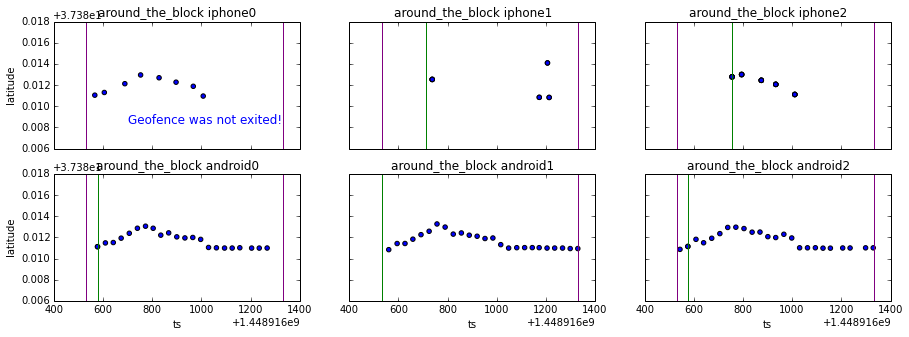

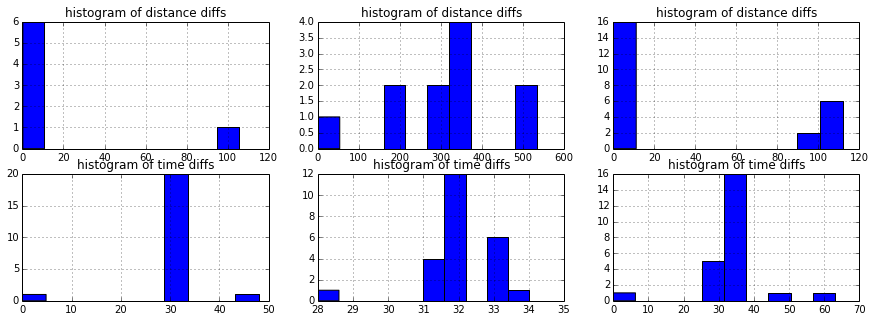

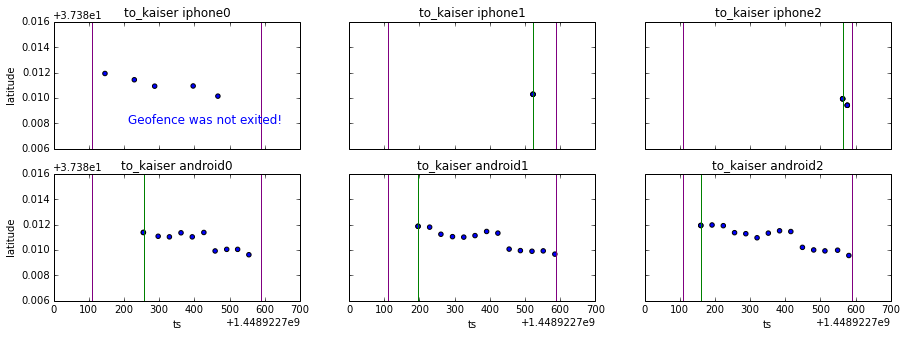

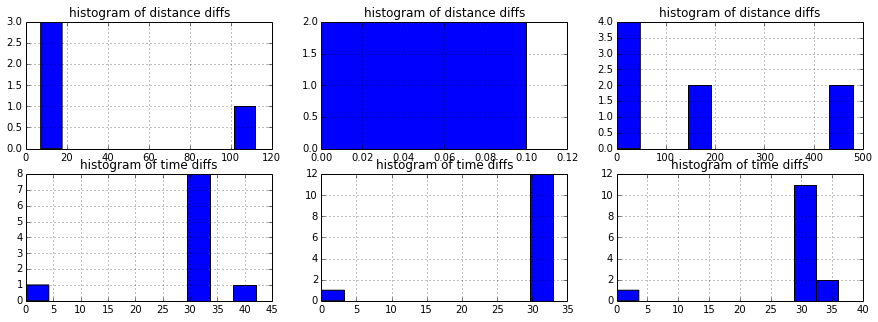

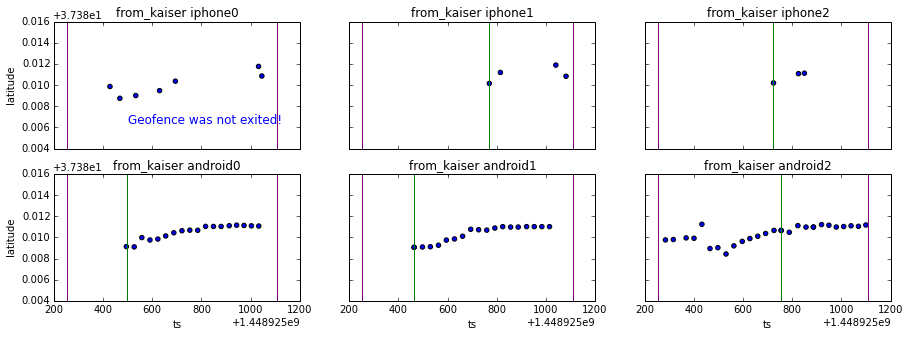

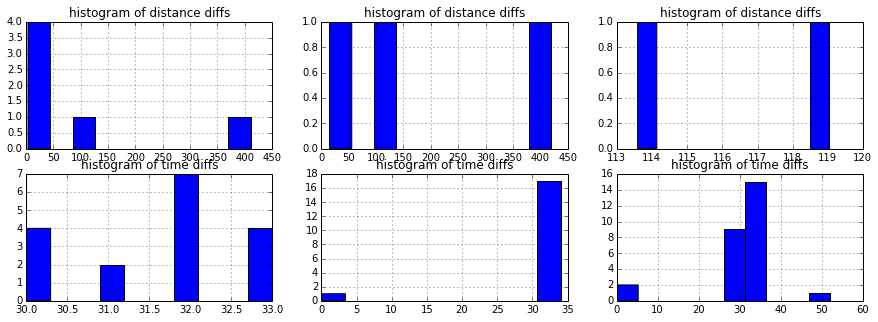

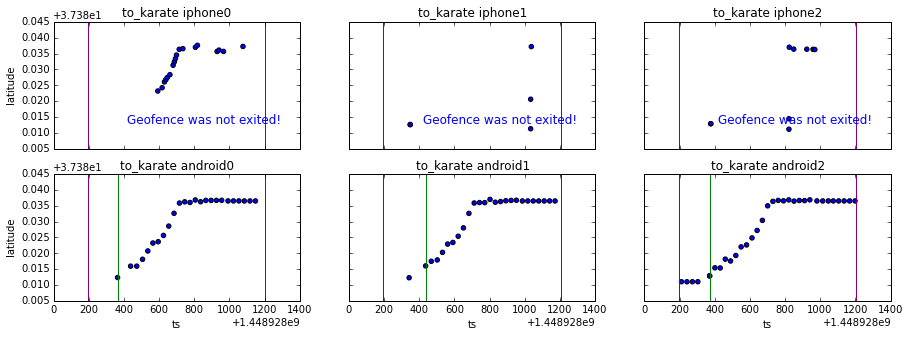

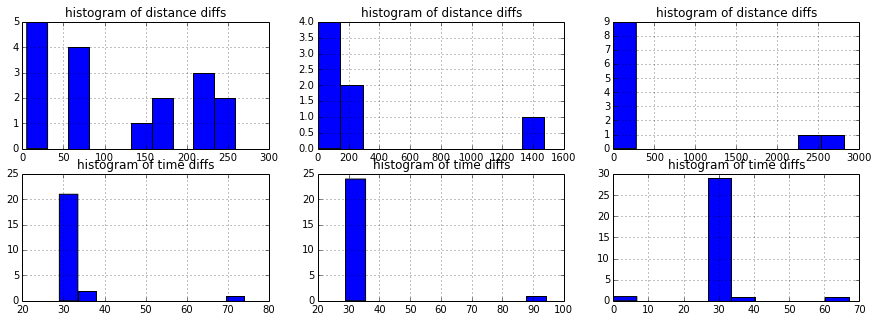

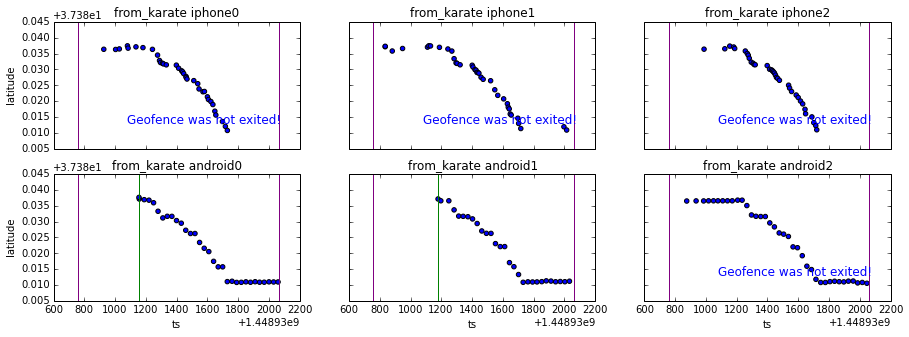

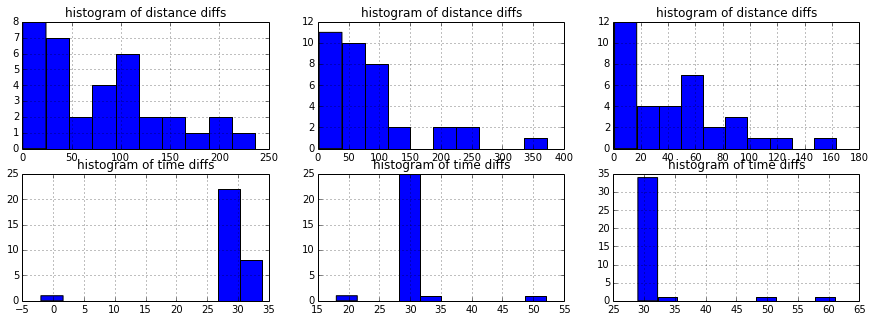

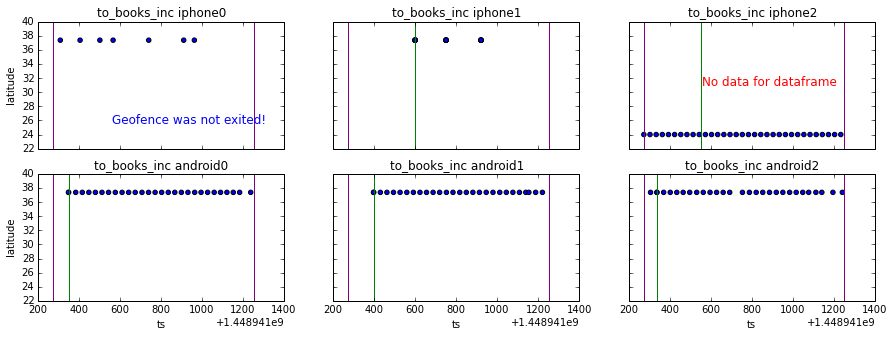

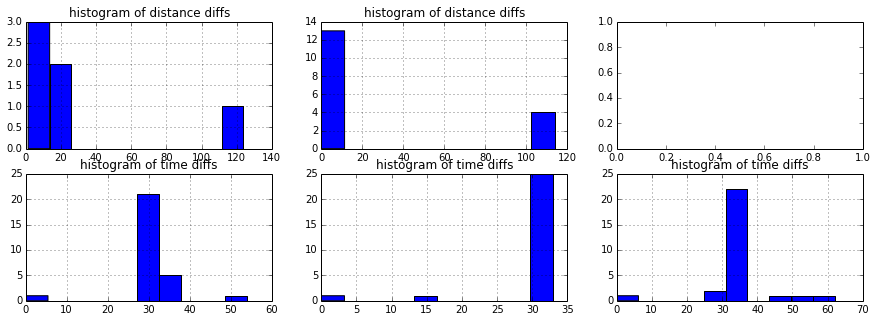

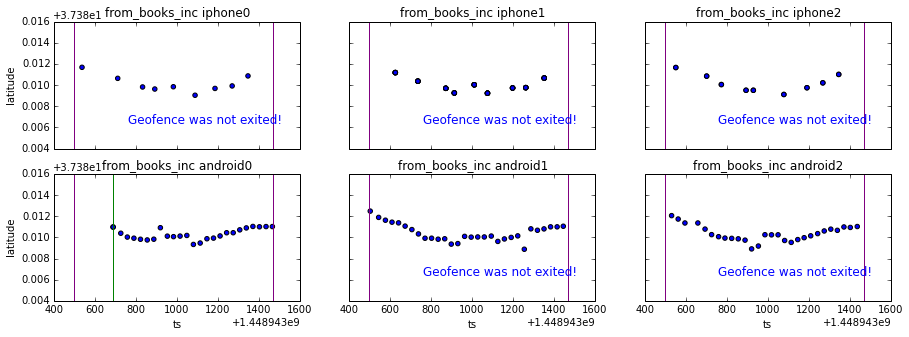

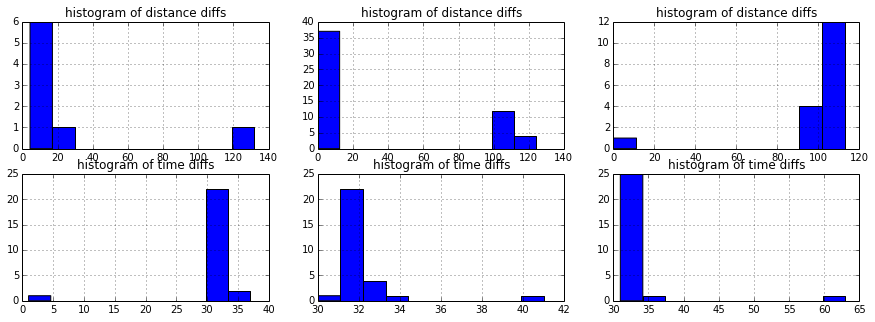

In [187]:
for label, start, end in trips_list:
    evaluate_trip_accuracy(label, start, end)